# 손글씨 숫자 인식 (MNIST)

**목표**: 손으로 쓴 숫자 이미지를 보고 0~9 중 어떤 숫자인지 맞추는 모델 만들기

---

## Step 0: 한글 폰트 설정

In [ ]:
!apt-get install -y fonts-nanum > /dev/null 2>&1

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

print("한글 폰트 설정 완료!")

한글 폰트 설정 완료!


## Step 1: 라이브러리 불러오기

In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

print("라이브러리 로드 완료!")

라이브러리 로드 완료!


## Step 2: MNIST 데이터 다운로드

In [ ]:
print("데이터 다운로드 중... (1-2분 소요)")

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype('int')

print(f"다운로드 완료!")
print(f"이미지 개수: {X.shape[0]:,}개")
print(f"피처 개수: {X.shape[1]}개 (28x28)")

데이터 다운로드 중... (1-2분 소요)
다운로드 완료!
이미지 개수: 70,000개
피처 개수: 784개 (28x28)


## Step 3: 데이터 시각화

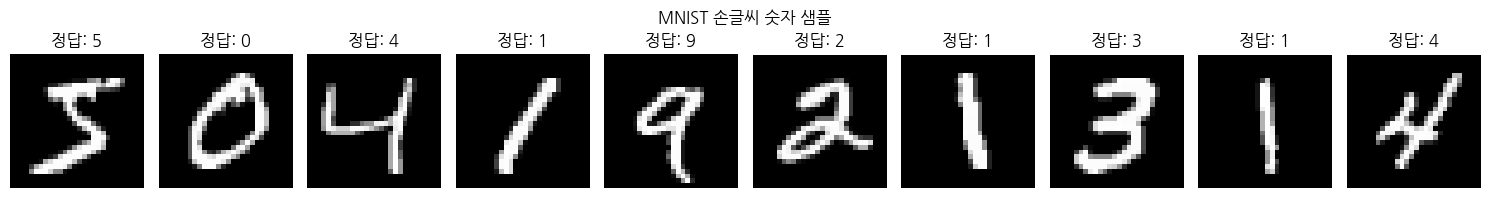

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(15, 2))

for i, ax in enumerate(axes):
    image = X[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.set_title(f'정답: {y[i]}')
    ax.axis('off')

plt.suptitle('MNIST 손글씨 숫자 샘플')
plt.tight_layout()
plt.show()

## Step 4: 학습 및 평가

In [ ]:
# 속도를 위해 10,000개만 사용
X_small, y_small = X[:10000], y[:10000]
X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.2, random_state=42)

print("모델 학습 중... (1-2분 소요)")
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f"\n모델 정확도: {accuracy:.2%}")

모델 학습 중... (1-2분 소요)

모델 정확도: 95.00%


## Step 5: 예측 결과 시각화

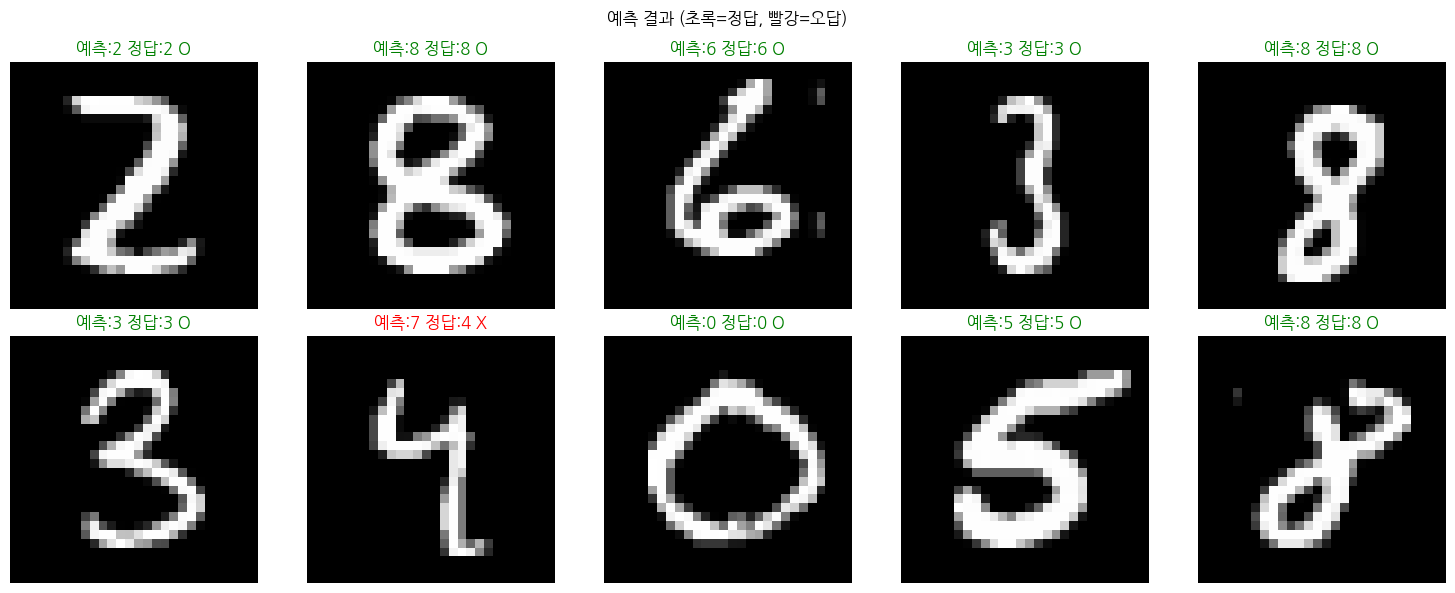

In [ ]:
y_pred = model.predict(X_test)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    image = X_test[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    color = 'green' if y_pred[i] == y_test[i] else 'red'
    mark = 'O' if y_pred[i] == y_test[i] else 'X'
    ax.set_title(f'예측:{y_pred[i]} 정답:{y_test[i]} {mark}', color=color)
    ax.axis('off')

plt.suptitle('예측 결과 (초록=정답, 빨강=오답)')
plt.tight_layout()
plt.show()

---

# 도전 과제: 내 손글씨 인식하기!

## 방법 1: 캔버스에 마우스로 그리기


예측 결과: 1
확신도: 34.0%


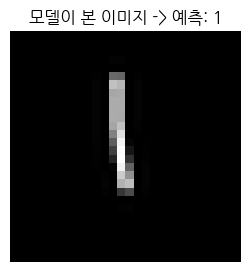


예측 결과: 6
확신도: 26.0%


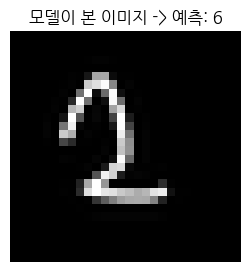


예측 결과: 7
확신도: 22.0%


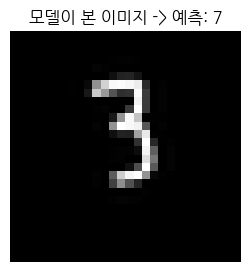

In [ ]:
from google.colab import output
from IPython.display import display, HTML
import base64
from io import BytesIO
from PIL import Image

canvas_html = """
<style>
  #canvas-container { text-align: center; margin: 20px; }
  #draw-canvas { border: 2px solid #333; cursor: crosshair; background: black; }
  button { margin: 5px; padding: 10px 20px; font-size: 16px; }
</style>
<div id="canvas-container">
  <h3>마우스로 숫자를 그려보세요! (0~9)</h3>
  <canvas id="draw-canvas" width="280" height="280"></canvas><br>
  <button onclick="clearCanvas()">지우기</button>
  <button onclick="predict()">예측하기</button>
</div>
<script>
  var canvas = document.getElementById('draw-canvas');
  var ctx = canvas.getContext('2d');
  var drawing = false;
  ctx.fillStyle = 'black';
  ctx.fillRect(0, 0, 280, 280);
  ctx.strokeStyle = 'white';
  ctx.lineWidth = 12;
  ctx.lineCap = 'round';
  canvas.onmousedown = function(e) { drawing = true; ctx.beginPath(); ctx.moveTo(e.offsetX, e.offsetY); };
  canvas.onmousemove = function(e) { if(drawing) { ctx.lineTo(e.offsetX, e.offsetY); ctx.stroke(); } };
  canvas.onmouseup = function() { drawing = false; };
  canvas.onmouseout = function() { drawing = false; };
  function clearCanvas() { ctx.fillStyle = 'black'; ctx.fillRect(0, 0, 280, 280); }
  function predict() { google.colab.kernel.invokeFunction('notebook.predict_digit', [canvas.toDataURL('image/png')], {}); }
</script>
"""

def predict_digit(data_url):
    img_data = base64.b64decode(data_url.split(',')[1])
    img = Image.open(BytesIO(img_data)).convert('L')
    img = img.resize((28, 28), Image.Resampling.LANCZOS)
    img_array = np.array(img).reshape(1, -1)

    prediction = model.predict(img_array)
    proba = model.predict_proba(img_array)[0]

    print(f"\n{'='*40}")
    print(f"예측 결과: {prediction[0]}")
    print(f"확신도: {proba[prediction[0]]*100:.1f}%")
    print(f"{'='*40}")

    plt.figure(figsize=(3, 3))
    plt.imshow(img_array.reshape(28, 28), cmap='gray')
    plt.title(f'모델이 본 이미지 -> 예측: {prediction[0]}')
    plt.axis('off')
    plt.show()

output.register_callback('notebook.predict_digit', predict_digit)
display(HTML(canvas_html))

## 방법 2: 웹캠으로 촬영하기

종이에 큰 숫자를 써서 카메라에 보여주세요!

In [ ]:
from IPython.display import Javascript
from google.colab.output import eval_js
import cv2

def take_photo(quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      div.innerHTML = '<h3>종이에 큰 숫자를 써서 카메라에 보여주세요! (3초 후 촬영)</h3>';
      document.body.appendChild(div);
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(video);
      video.srcObject = stream;
      await video.play();
      await new Promise((resolve) => setTimeout(resolve, 3000));
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks()[0].stop();
      div.remove();
      video.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = base64.b64decode(data.split(',')[1])
    with open('photo.jpg', 'wb') as f:
        f.write(binary)
    return 'photo.jpg'

print("웹캠 준비 완료! 아래 셀을 실행하면 3초 후 자동 촬영됩니다.")

웹캠 준비 완료! 아래 셀을 실행하면 3초 후 자동 촬영됩니다.


카메라 시작... 종이에 쓴 숫자를 보여주세요!


<IPython.core.display.Javascript object>

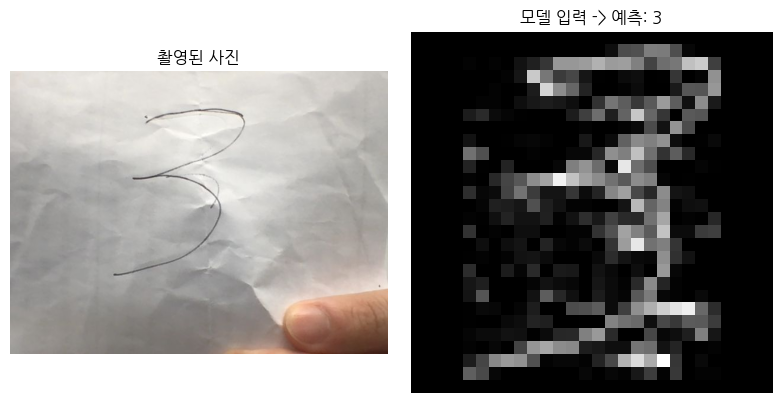


예측 결과: 3


In [ ]:
 # 웹캠 촬영 및 예측 실행
print("카메라 시작... 종이에 쓴 숫자를 보여주세요!")

try:
    filename = take_photo()

    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    # 1. 가우시안 블러 (노이즈 제거)
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # 2. 적응형 이진화 (조명 대응)
    img = cv2.adaptiveThreshold(img, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # 3. 숫자 영역만 찾아서 crop + 가운데 정렬
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # 가장 큰 영역 찾기
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        digit = img[y:y+h, x:x+w]

        # 정사각형 패딩 (가운데 정렬)
        size = max(w, h)
        padded = np.zeros((size, size), dtype=np.uint8)
        px, py = (size - w) // 2, (size - h) // 2
        padded[py:py+h, px:px+w] = digit

        # 여백 추가 (MNIST 스타일)
        padded = np.pad(padded, 20, mode='constant', constant_values=0)
        img = padded

    # 4. 28x28 리사이즈
    img = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA)

    prediction = model.predict(img.reshape(1, -1))

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    original = cv2.imread(filename)
    axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axes[0].set_title('촬영된 사진')
    axes[0].axis('off')
    axes[1].imshow(img, cmap='gray')
    axes[1].set_title(f'모델 입력 -> 예측: {prediction[0]}')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

    print(f"\n예측 결과: {prediction[0]}")
except Exception as e:
    print(f"오류: {e}")
    print("웹캠 권한을 허용해주세요!")